In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf 
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
from google.colab import drive
import os

# Mount drive
drive.mount('/content/gdrive')
PROJECT_PATH = '/content/gdrive/My Drive/DL_04/'

# List loaded files 
print(os.listdir(PROJECT_PATH))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['GoogleNews-vectors-negative300.bin.gz', 'glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt', 'glove.twitter.27B.50d.txt', 'glove.twitter.27B.100d.txt', 'glove.twitter.27B.200d.txt', 'test_emoji.csv', 'train_emoji.csv', 'GoogleNews-vectors-negative300.bin']


In [0]:
import pandas as pd

# Load train and test dataset 
train_ds = pd.read_csv(PROJECT_PATH + 'train_emoji.csv',  header=None, usecols=[0,1], names=['sentence', 'emoji'])
test_ds = pd.read_csv(PROJECT_PATH + 'test_emoji.csv',  header=None, usecols=[0,1], names=['sentence', 'emoji'])

# Show data type - I had to bit modify the test data - they werent in the same format 
# and in with the tabulator at the end of the sentence
display(train_ds.head(2))

,sentence,emoji
0,never talk to me again,3
1,I am proud of your achievements,2


In [0]:
# Split train, test dataset
X_train, y_train = train_ds['sentence'], train_ds['emoji']
X_test, y_test = test_ds['sentence'], test_ds['emoji']


display(X_train.head(2))
display(y_train.head(2))


0             never talk to me again
1    I am proud of your achievements
Name: sentence, dtype: object

0    3
1    2
Name: emoji, dtype: int64

In [0]:
# Convert y_data to one-hot encoding
y_train_oh = pd.get_dummies(y_train)
y_test_oh = pd.get_dummies(y_test)


display(y_train_oh.head(2))


,0,1,2,3,4
0,0,0,0,1,0
1,0,0,1,0,0


In [0]:
!pip3 install emoji
import emoji

# Prepare and show emoji dictionary
emoji_dict = {  0: emoji.emojize(":heart:", use_aliases=True),   
                1: emoji.emojize(":baseball:", use_aliases=True),
                2: emoji.emojize(":smile:", use_aliases=True),
                3: emoji.emojize(":disappointed:", use_aliases=True),
                4: emoji.emojize(":fork_and_knife:", use_aliases=True)}

print("Emoji tagrets:")
for i in range(5):
    print("\t" + emoji_dict[i])

Emoji tagrets:
	❤
	⚾
	😄
	😞
	🍴


In [0]:
import numpy as np


# Loading w2v dictanionary
# https://www.kaggle.com/ankitswarnkar/word-embedding-using-glove-vector
def get_w2v_dict(file_name="glove.twitter.27B.50d.txt"):
    with open(PROJECT_PATH + file_name,'r') as f:
        word2vector = {}
        for line in f:
            line_ = line.strip() 
            words_Vec = line_.split()
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    return word2vector


## Code for task #1: 
Convert sentences to average word embeddings (after converting every 
sentence to lower-case, and splitting the sentence into a list of words).
Alternatively, convert sentences to min and max word embeddings (by
taking element-wise min or max over the word embedding vectors).

In [0]:
# Encoding data to vector reprezentation
def get_encoded_data(data=None, emb_type="mean", v2w_dict=None):
    X_train_encoded = []
    for sentence in data: 
        sentence_words = (sentence.lower()).split()

        encoded_words = []
        for word in sentence_words: 
            try:
                encoded_words.append(v2w_dict[word])
            except KeyError:
                pass
                print("Word Not found: " + word  )
        
        emb_mean = np.mean(encoded_words, axis=0)
        emb_min = np.min(encoded_words, axis=0)
        emb_max = np.max(encoded_words, axis=0)
        
        if emb_type == "mean":
            X_train_encoded.append(emb_mean)
        elif emb_type == "min":
            X_train_encoded.append(emb_min)
        elif emb_type == "max":
            X_train_encoded.append(emb_max)
        elif emb_type == "combined":
            tmp = np.concatenate((emb_mean, emb_min), axis=0)
            tmp2 = np.concatenate((tmp, emb_max), axis=0)
            X_train_encoded.append(tmp2)

    shape = X_train_encoded[0].shape
    X_train_df = pd.DataFrame(data=X_train_encoded) 
    return X_train_df, shape



In [0]:
# Single layer softmax model 
def get_compiled_model(input_shape):

    initializer = tf.initializers.VarianceScaling(scale=2.0)
    inputs = tf.keras.Input(shape=input_shape)
    flattened_inputs = tf.keras.layers.Flatten()(inputs)
    scores = tf.keras.layers.Dense(5, activation='softmax',
                             kernel_initializer=initializer)(flattened_inputs)

    # Instantiate the model given inputs and outputs.
    model = tf.keras.Model(inputs=inputs, outputs=scores)

    sgd = tf.keras.optimizers.SGD(lr=0.01, decay=0.000225, momentum=0.5)

    model.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model


In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Turn off errors for nicer otuput
tf.get_logger().setLevel('ERROR')


# Confusion matrix modified from: 
# https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo/blob/master/SentimentAnalysisProject/emo_utils.py
def plot_confusion_matrix(y_actu, y_pred):
    cmap=plt.cm.gray_r
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) 

    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))

    labels = [emoji_dict[x] for x in range(5)]
    labels.append("All")

    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)

    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)



def train_model( w2v_dict=None, emb_type="mean", dict_dataset="Glove Twitter", display_details=False):
    
    X_train_encoded, input_shape = get_encoded_data(X_train,emb_type=emb_type, v2w_dict=w2v_dict)
    X_test_encoded, _ = get_encoded_data(X_test, emb_type=emb_type, v2w_dict=w2v_dict)

    model = get_compiled_model(input_shape)

    
    model.fit(X_train_encoded,
              y_train_oh,
              epochs=X_train_encoded.shape[0],
              verbose=False)
    
    
    loss, acc = model.evaluate(X_test_encoded,
                           y_test_oh,
                           steps=X_test_encoded.shape[0], 
                           verbose=False)

    print(f"Model using {dict_dataset} dict with {emb_type} embedding encoding to vector size of {input_shape} has accuracy of {acc}")

    if display_details == False:
        return 

    test_samples_len = X_test_encoded.shape[0]
    y_pred = np.zeros(test_samples_len)
    predictions = model.predict(X_test_encoded)
    


    for i in range(test_samples_len):
        y_pred[i] = np.argmax(predictions[i])

    plot_confusion_matrix(y_test, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r)
    correct = []
    wrong = []
  
    
    for i in range(test_samples_len):
        if y_pred[i] == y_test[i]:
            correct.append("Correct prediction for: {0:<50} Expected/Predicted: {1:<1}/{2:<1}".format(X_test[i], emoji_dict[y_test[i]], emoji_dict[y_pred[i]] ))
        else:
            wrong.append("Wrong prediction for: {0:<50} Expected/Predicted: {1:<1}/{2:<1}".format(X_test[i], emoji_dict[y_test[i]], emoji_dict[y_pred[i]] ))

    print("\n\nCorrect predictions:")
    for i in range(10):
        print("{0:>3}) ".format(str(i+1)) +  correct[i])
    
    print("\n\nWrong predictions:")
    for i in range(10):
        print("{0:>3}) ".format(str(i+1)) + wrong[i])


In [0]:
# Load vocabs: 

# twitter dict 
w2v_twit_50 = get_w2v_dict("glove.twitter.27B.50d.txt")
w2v_twit_100 = get_w2v_dict("glove.twitter.27B.100d.txt")
w2v_twit_200 = get_w2v_dict("glove.twitter.27B.200d.txt")

# wiki dict
w2v_wiki_50 = get_w2v_dict("glove.6B.50d.txt")
w2v_wiki_100 = get_w2v_dict("glove.6B.100d.txt")
w2v_wiki_200 = get_w2v_dict("glove.6B.200d.txt")

## Answers and output for task #2

Use GloVe embeddings of size 50 (trained on Twitter) to train and evaluate the classification model described above. 

**Show the confusion matrix.**
> In the cell output

**What is the accuracy of the classifier on the test dataset?** 
> In the cell output

**Show 10 examples that are correctly classified by the model trained, and 10 examples that are misclassified by the model.**
> In the cell output


**Are the results surprising at all?**

_For me it was a bit suprising, how good the model actually got, given the fact it was trained on small dataset and sentences from test dataset had a lot of unseen words._

_On the otherhand it demonstrates, how well are the words encoded in embedding vector._


**Can you explain the misclassifications?**
 
_In some cases the misclassification I think can be explained as only missing true positive response such as with some close words from train dataset wich are in similar vector space. These sentencs would be:_
> I miss you so much                                 Expected/Predicted: ❤/😄

> My grandmother is the love of my life              Expected/Predicted: ❤/😄
 
> she got me a nice present                          Expected/Predicted: 😄/❤

> where is the food                                  Expected/Predicted: 🍴/😄

> I love taking breaks                               Expected/Predicted: ❤/😞

_In some cases it is just from low amount of data:_
> you brighten my day                                Expected/Predicted: 😄/😞

> she is a bully                                     Expected/Predicted: 😞/😄

> enjoy your game                                    Expected/Predicted: ⚾/😞

_And here probably average "work is" embedding is close and to learned wight for smiley predictions_

> work is hard                                       Expected/Predicted: 😞/😄

> work is horrible                                   Expected/Predicted: 😞/😄



Model using Glove Twitter dict with mean embedding encoding to vector size of (50,) has accuracy of 0.6071428656578064


Correct predictions:
  1) Correct prediction for: I want to eat                                      Expected/Predicted: 🍴/🍴
  2) Correct prediction for: he did not answer                                  Expected/Predicted: 😞/😞
  3) Correct prediction for: he got a very nice raise                           Expected/Predicted: 😄/😄
  4) Correct prediction for: ha ha ha it was so funny                           Expected/Predicted: 😄/😄
  5) Correct prediction for: he is a good friend                                Expected/Predicted: 😄/😄
  6) Correct prediction for: I am upset                                         Expected/Predicted: 😞/😞
  7) Correct prediction for: We had such a lovely dinner tonight                Expected/Predicted: 😄/😄
  8) Correct prediction for: Stop making this joke ha ha ha                     Expected/Predicted: 😄/😄
  9) Correct prediction fo

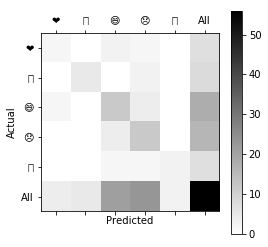

In [0]:
train_model( w2v_dict=w2v_twit_50, emb_type="mean", dict_dataset="Glove Twitter", display_details=True)

## Anwers and output for task #3
Compare the results (accuracy) of the models obtained with avg/min/max sentence representations, respectively. 

**Which representation gives the best results?**
> Results in a cell outputs

_Depends on a run, all are pretty close to each other in  terms of accuracy on test data, in this case best score achieved by a min sentece embedding (0.64)._

**Do the results improve if you use avg/min/max together (in this case, the sentence vectors will be 3x50)?**

_Yes quite a lot, more information improvess accuracy to 0.76._ 

In [0]:

train_model( w2v_dict=w2v_twit_50, emb_type="mean", dict_dataset="Glove Twitter", display_details=False)
train_model( w2v_dict=w2v_twit_50, emb_type="min", dict_dataset="Glove Twitter", display_details=False)
train_model( w2v_dict=w2v_twit_50, emb_type="max", dict_dataset="Glove Twitter", display_details=False)
train_model( w2v_dict=w2v_twit_50, emb_type="combined", dict_dataset="Glove Twitter", display_details=False)

Model using Glove Twitter dict with mean embedding encoding to vector size of (50,) has accuracy of 0.6071428656578064
Model using Glove Twitter dict with min embedding encoding to vector size of (50,) has accuracy of 0.6785714030265808
Model using Glove Twitter dict with max embedding encoding to vector size of (50,) has accuracy of 0.6428571343421936
Model using Glove Twitter dict with combined embedding encoding to vector size of (150,) has accuracy of 0.7678571343421936


## Answers and output for task #5

Train models using the 50d, 100d, and 200d Glove embeddings using both
the set trained on Wikipedia and the set trained on Twitter. 

**For each set, what embedding dimension gives better results?** 
_Here the bigger embedding size is the better are the results for both of the wiki/twitter datasets_ 

**Between the two sets (Wikipedia versus Twitter), which one performs better?**

_In average wikidia set has better results_

In [0]:
train_model( w2v_dict=w2v_twit_50, emb_type="mean", dict_dataset="Glove Twitter", display_details=False)
train_model( w2v_dict=w2v_twit_100, emb_type="mean", dict_dataset="Glove Twitter", display_details=False)
train_model( w2v_dict=w2v_twit_200, emb_type="mean", dict_dataset="Glove Twitter", display_details=False)

train_model( w2v_dict=w2v_wiki_50, emb_type="mean", dict_dataset="Glove Wiki", display_details=False)
train_model( w2v_dict=w2v_wiki_100, emb_type="mean", dict_dataset="Glove Wiki", display_details=False)
train_model( w2v_dict=w2v_wiki_200, emb_type="mean", dict_dataset="Glove Wiki", display_details=False)

Model using Glove Twitter dict with mean embedding encoding to vector size of (50,) has accuracy of 0.6428571343421936
Model using Glove Twitter dict with mean embedding encoding to vector size of (100,) has accuracy of 0.6964285969734192
Model using Glove Twitter dict with mean embedding encoding to vector size of (200,) has accuracy of 0.75
Model using Glove Wiki dict with mean embedding encoding to vector size of (50,) has accuracy of 0.6785714030265808
Model using Glove Wiki dict with mean embedding encoding to vector size of (100,) has accuracy of 0.6607142686843872
Model using Glove Wiki dict with mean embedding encoding to vector size of (200,) has accuracy of 0.7857142686843872


In [0]:
# Making RAM space 
del w2v_twit_50
del w2v_twit_100
del w2v_twit_200
del w2v_wiki_50
del w2v_wiki_100
del w2v_wiki_200

In [0]:
!pip3 install gensim
from gensim import models

model = models.KeyedVectors.load_word2vec_format(PROJECT_PATH + 'GoogleNews-vectors-negative300.bin.gz', binary=True)


## Answers and output for task #4

Use 300d Word2vec and 300d Glove embeddings (trained on Wikipedia) to train the model with the average word embedding representation for sentences. 

**Between 300dWord2vec embeddings and 300d GloVe embeddings, which set performs better?**

_The glove ouperformed the 300dWord2vec, but both are does not perform better than the 200d._


In [0]:
w2v_gn_300 = model.wv

train_model( w2v_dict=w2v_gn_300, emb_type="mean", dict_dataset="Word2Vec Google News", display_details=False)

# Free memory again
del model
del w2v_gn_300


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


Model using Word2Vec Google News dict with mean embedding encoding to vector size of (300,) has accuracy of 0.5892857313156128


In [0]:
w2v_gn_300 = get_w2v_dict("glove.6B.300d.txt")
train_model( w2v_dict=w2v_gn_300, emb_type="mean", dict_dataset="Glove Wiki", display_details=False)

Model using Glove Wiki dict with mean embedding encoding to vector size of (300,) has accuracy of 0.7321428656578064
